In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Import the data

In [231]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

df = load_housing_data()

In [232]:
# Take a quick look at a sample of the data
df['median_income'] *= 10000
df.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9359,-120.65,35.27,15.0,2365.0,538.0,1446.0,490.0,25129.0,225900.0,NEAR OCEAN
11840,-117.18,32.83,31.0,1772.0,353.0,1090.0,350.0,39265.0,162000.0,NEAR OCEAN
5781,-117.69,33.65,16.0,5805.0,852.0,2356.0,795.0,61062.0,274600.0,<1H OCEAN
2907,-117.76,33.53,28.0,3085.0,499.0,1176.0,480.0,79794.0,426100.0,<1H OCEAN
16280,-117.89,34.07,32.0,2374.0,450.0,1580.0,427.0,38837.0,200300.0,<1H OCEAN


In [233]:
# Take a quick look at the descroption of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [234]:
# Using the 'describe' function to have a look at the summary of the numerical attributes
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,38706.710029,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,18998.217179,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,4999.000000,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,25634.000000,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,35348.000000,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,47432.500000,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,150001.000000,500001.000000


In [235]:
# Looking at the categories of the 'ocean_proximity' feature
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Observations:
* There are some missing values in the 'total_bedrooms' feature. I will take a look at this thing later.
* 'ocean_proximity' is a categorical type and all the other features are of float type. 
* 'median_income' feature is not expressed in USD. It might be encoded to some values or maybe some other currencies might be used here.

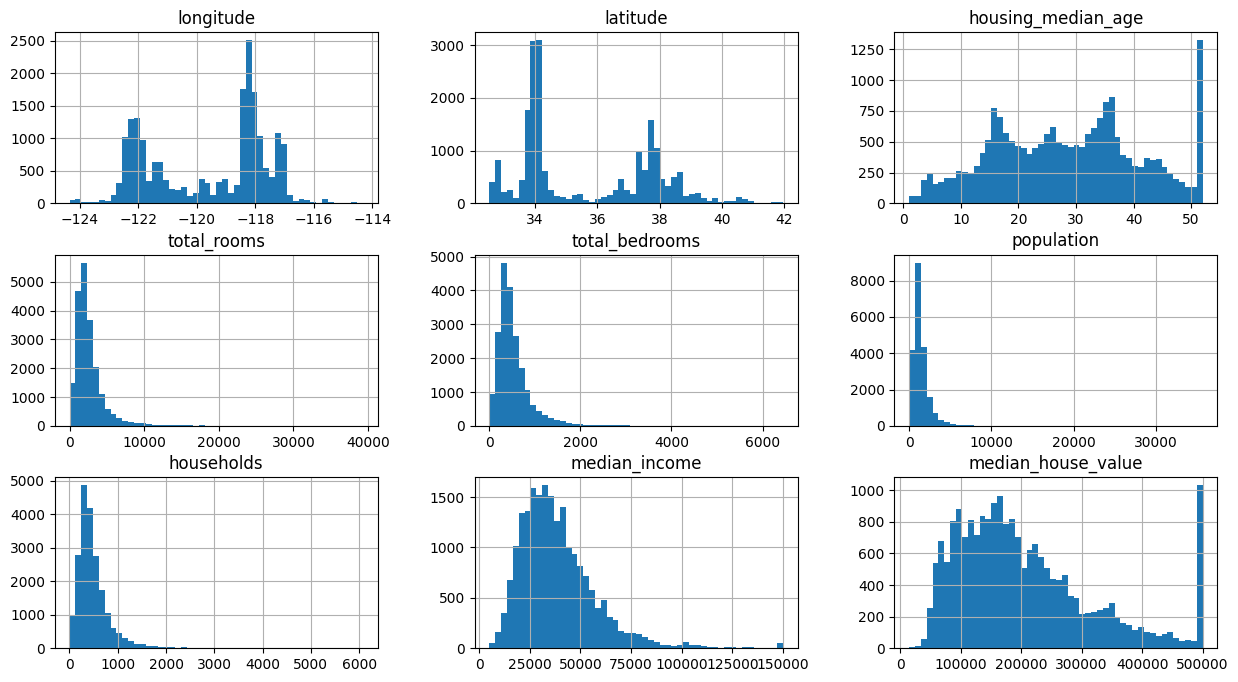

In [236]:
# Plot a histogram of our data

df.hist(bins = 50,figsize = (15,8))
plt.show()

Observations:
* 'housing_median_age' feature has been capped on the higher end. 
* Another feature which has been capped is the 'mediaan_house_value'. This is our target variable and it has also been capped at 500K. We need to do something about this. Otherwise our model will think that the 'housing_median_age' value does not go over 50 at all. This could be a problem for us.
* Most of our features are heavy tailed features and I will try to make these features more uniform.
* 'median_income' does not have the same scale as that of the 'median_house_value'.
* All of these attrivutes have different scales.

#### Splitting our data into training and testing sets

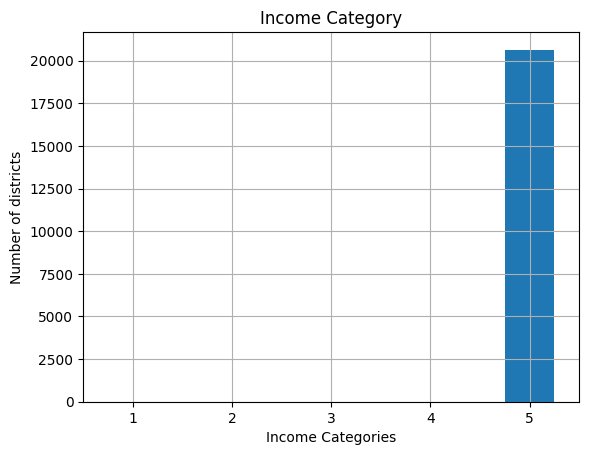

In [237]:
# I want to use stratified sampled based on the 'median_income' feature. I will use the pd.cut fucniton to do this

df['income_categories'] = pd.cut(df['median_income'],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])
df['income_categories'].value_counts().sort_index().plot(kind = 'bar',rot = 0,grid = True)
plt.title('Income Category')
plt.xlabel('Income Categories')
plt.ylabel('Number of districts')
plt.show()

In [238]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(df,test_size = 0.2,random_state = 7,stratify=df['income_categories'])

In [239]:
for i in (train_set,test_set):
    i.drop('income_categories',inplace = True,axis = 1)

#### Exploratory Data Analysis

In [240]:
# Create a copy of our data
housing = train_set.copy()

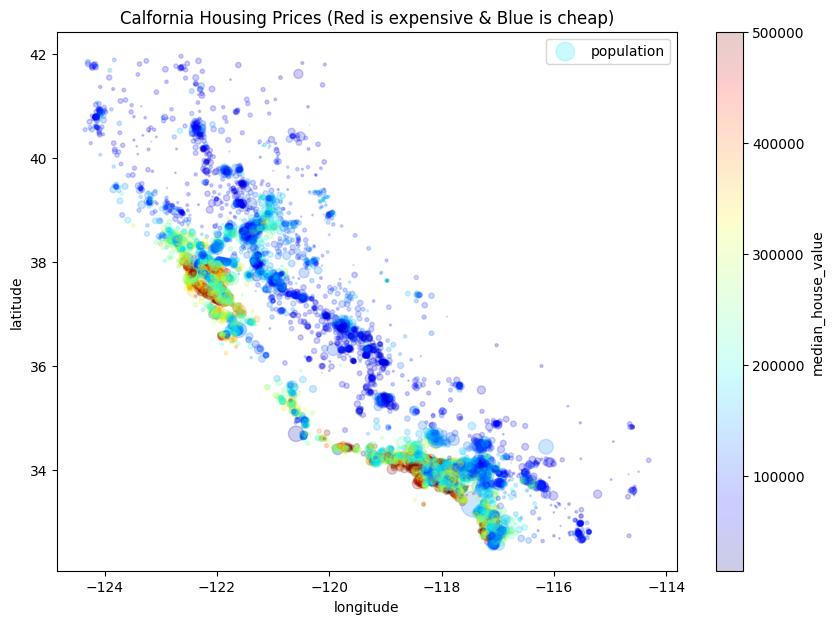

In [241]:
# Visualizing the geographical data
housing.plot(kind = 'scatter',x = 'longitude',y='latitude',alpha = 0.2, s= housing["population"]/100,label = "population",c = 'median_house_value',cmap = 'jet',colorbar=True,legend=True, sharex=False, figsize=(10, 7))
plt.title('Calfornia Housing Prices (Red is expensive & Blue is cheap)')
plt.show()

Observations:
* Houses around the coastal area are more expensive as compared to housed that are more inland
* Similar is the case with the population density as well

<Axes: >

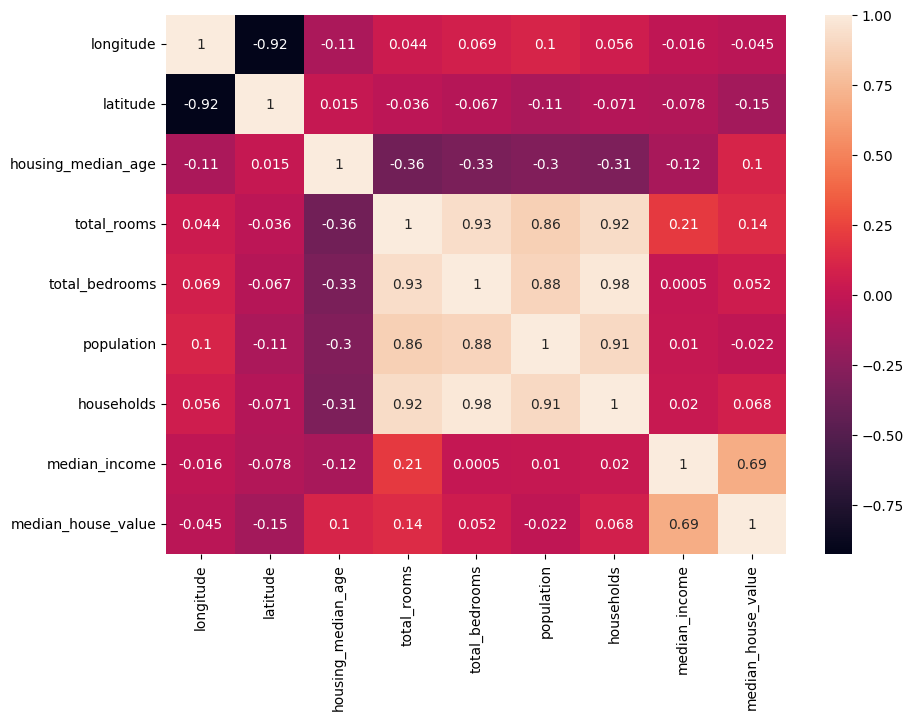

In [242]:
# Take a look at the correlation matrix
numeric_columns = housing.select_dtypes(include=['number']).columns
numeric_columns
plt.figure(figsize=(10, 7))
sns.heatmap(housing[numeric_columns].corr(),annot=True)

Observations:
* The target variable 'median_house_value' is highly correlated with the 'median_income' feature. It also has a slight positive correaltion with the 'housing_median_age' and the 'total_rooms' feature. 'median_house_age' is negative correlated with the latitude feature.
* Many of the features are correlated with each other. There can be a problem pertaining to multi-collinearity in this case. 'households' feature is highly correlated with the 'total_rooms','population' as well as the 'total_bedrooms' features. This will possess a huge problem in case of distance based algorithms. I will drop the 'households' feature later.

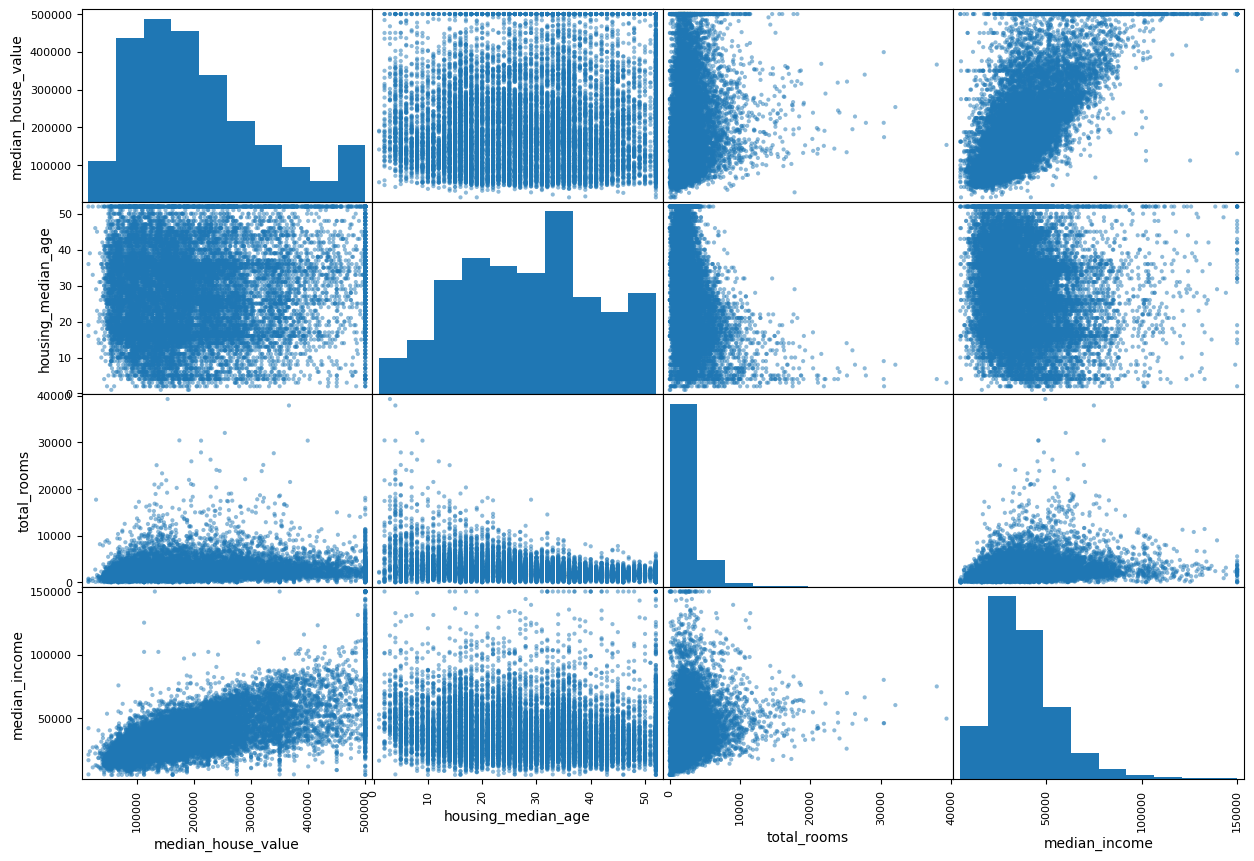

In [243]:
# Plot a scatter matrix to have a look at our most promosing features (Features that have some correlation with the target variable)
from pandas.plotting import scatter_matrix

imp_features = ['median_house_value','housing_median_age','total_rooms','median_income']

scatter_matrix(housing[imp_features],figsize = (15,10))
plt.show()

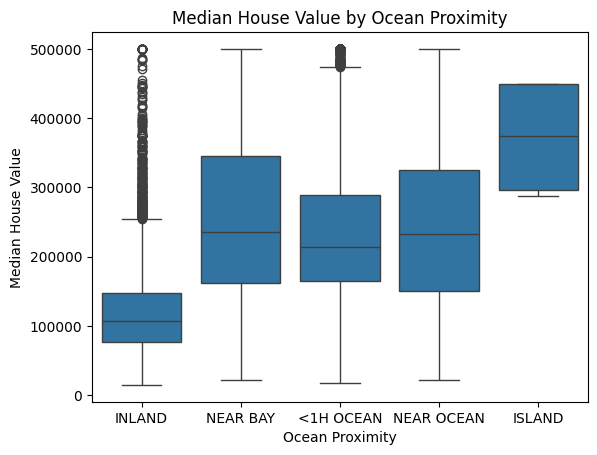

In [244]:
sns.boxplot(x='ocean_proximity', y='median_house_value', data=housing)
plt.title('Median House Value by Ocean Proximity')
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.show()

Observations:
* 'median_house_value' has an upper cap. There are some more horizontal lines well when we look at the 'median_income' vs the 'median_house_value' plot.
* Houses in the island are the most expense and the houses which are inland are the least expensive houses. THere are a lot of outliers present in the inland houses.

#### Feature Engineering

In [245]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

# Dropping the 'households' and the 'total_bedrooms' features to deal with collinearity.
housing.drop(['households','total_bedrooms','longitude','latitude'],axis = 1,inplace = True)

Observation:
* I have performed this transformation on housing. Housing was a dataset which was a copy of the training set. I will create pipelines moving forward which will apply these transformations on both the training as well as the testing sets.
* Add new features
* Drop features with multi-collinearity issue ('households' and 'total_bedrooms')

<Axes: >

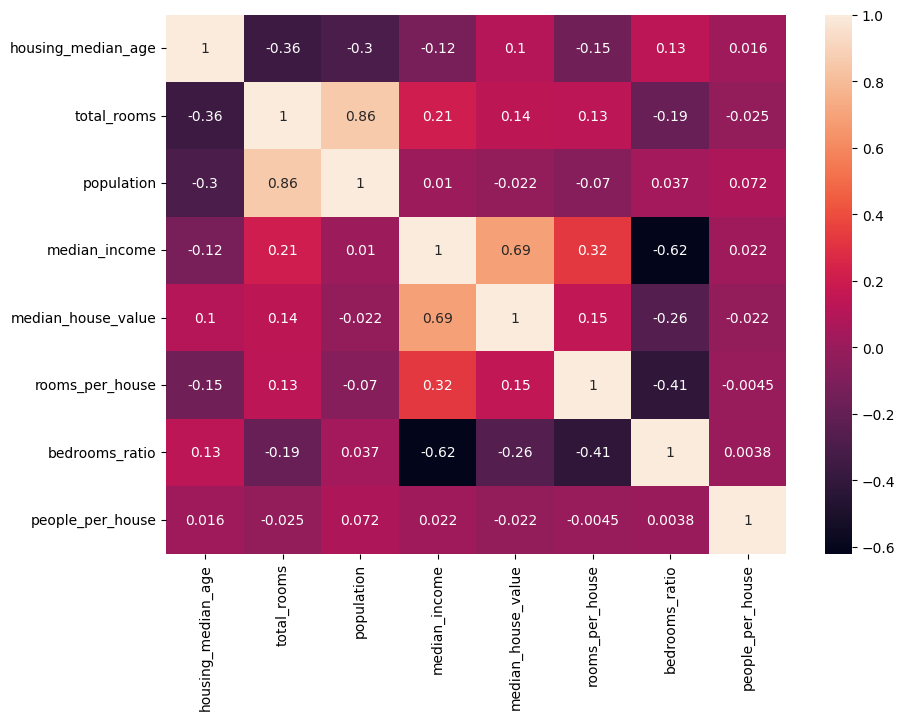

In [246]:
# Plot the correlation matrix again
numeric_columns = housing.select_dtypes(include=['number']).columns
numeric_columns
plt.figure(figsize=(10, 7))
sns.heatmap(housing[numeric_columns].corr(),annot=True)

Observations:
* 'bedrooms_ratio' is a newly created feature which is negatively correlated with the 'median_house_value' feature.

In [247]:
#Revert back to fresh data and split the data into X_train,X_test,y_train and y_test

X_train = train_set.drop("median_house_value",axis = 1)
y_train = train_set['median_house_value']

X_test = test_set.drop('median_house_value',axis = 1)
y_test = test_set['median_house_value']

#### Transformation Pipelines

In [248]:
#Revert back to fresh data and split the data into X_train,X_test,y_train and y_test
X_train = train_set.drop("median_house_value",axis = 1)
y_train = train_set['median_house_value']

X_test = test_set.drop('median_house_value',axis = 1)
y_test = test_set['median_house_value']

# Add some new features - 'rooms_per_house','bedrooms_ratio' and 'people_per_house' {Feature Engineering}

X_train["rooms_per_house"] = X_train["total_rooms"] / X_train["households"]
X_train["bedrooms_ratio"] = X_train["total_bedrooms"] / X_train["total_rooms"]
X_train["people_per_house"] = X_train["population"] / X_train["households"]

X_test["rooms_per_house"] = X_test["total_rooms"] / X_test["households"]
X_test["bedrooms_ratio"] = X_test["total_bedrooms"] / X_test["total_rooms"]
X_test["people_per_house"] = X_test["population"] / X_test["households"]

# Drop the features 'households' and 'total_bedrooms' which posses multi-collinearity problems 
X_train = X_train.drop(['households','total_bedrooms','longitude','latitude'],axis = 1)
X_test = X_test.drop(['households','total_bedrooms','longitude','latitude'],axis = 1)

# Create log pipelines for transforming heavy-tailed features to a normal distribution
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

log_pipeline = make_pipeline(SimpleImputer(strategy= "median"),FunctionTransformer(np.log),StandardScaler())

# Create a pipeline for the categorical features
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

# Create a pipeline for the numerical features
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

# Create a ColumnTransformer
from sklearn.compose import ColumnTransformer,make_column_selector

preprocessing = ColumnTransformer([
    ("log_transform",log_pipeline,[1,2,3]),
    ("cat_transform",cat_pipeline,[4]),
    ("num_transform",num_pipeline,[0,5,6,7])
],
remainder = "passthrough")

X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)

X_train_preprocessed.shape

(16512, 12)

In [249]:
X_train.sample(5)

,housing_median_age,total_rooms,population,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
14714,28.0,3109.0,1559.0,35789.0,NEAR OCEAN,5.278438,0.191058,2.646859
895,34.0,2629.0,1301.0,60830.0,<1H OCEAN,6.099768,0.164701,3.018561
273,41.0,2067.0,1282.0,55756.0,<1H OCEAN,4.542857,0.218674,2.817582
17971,35.0,2091.0,879.0,44485.0,<1H OCEAN,6.414110,0.172166,2.696319
16948,5.0,1387.0,855.0,54110.0,INLAND,5.137037,0.170151,3.166667


#### Model Training and Evaluation

In [250]:
# Apply the Linear Regression model

from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing,LinearRegression())
lin_reg.fit(X_train,y_train)

# Get the predictions on the training data to have a look at the training error
y_pred_train_lin_reg = lin_reg.predict(X_train)

from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_train,y_pred_train_lin_reg)

np.float64(72217.44334354348)

Observation:
* The training error for this model seems to be quite high to me. Seems like the model is underfitting. Need to use a more complex model. Will use a Decition Tree now

In [251]:
# Try out a Decision Tree model

from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing,DecisionTreeRegressor())
tree_reg.fit(X_train,y_train)

# Get the predictions on the training data to have a look at the training error
y_pred_train_tree_reg = tree_reg.predict(X_train)

root_mean_squared_error(y_train,y_pred_train_tree_reg)

np.float64(0.0)

Observation:
* We get our training error as zero. Our model is overfitting in this case. We will use cross validation to evaluate our model

In [252]:
from sklearn.model_selection import cross_val_score

pd.Series(-cross_val_score(tree_reg,X_train,y_train, scoring='neg_root_mean_squared_error',cv = 10)).describe()

count       10.000000
mean     83124.638443
std       2063.082004
min      80936.031314
25%      81960.302909
50%      82402.540809
75%      83801.204084
max      87643.751154
dtype: float64

In [253]:
# Try the random forest model

from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,RandomForestRegressor())
forest_reg.fit(X_train,y_train)

# Get the predictions on the training data to have a look at the training error
y_pred_train_forest_reg = forest_reg.predict(X_train)

print(f"The training error for our Random Forest Regression model is {root_mean_squared_error(y_train,y_pred_train_forest_reg)}")

# Compute the cross validation score to check for any overfitting in the model
from sklearn.model_selection import cross_val_score

cross_val_forest_regression = -cross_val_score(forest_reg,X_train,y_train,scoring= "neg_root_mean_squared_error",cv = 10).mean()

print(f"The cross validation score for our Random Forest Regression model is {cross_val_forest_regression}")

The training error for our Random Forest Regression model is 22111.70934755003
The cross validation score for our Random Forest Regression model is 59231.43249465358


Observations:
* The training error for our random forest model is less and the validation error for this model is high. There is still some overfitting going on here.
* I will go ahead with using this model. I will fine tine the model further and try to regularize the model for our use.

In [254]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Make a full-pipeline with our Random Forest model. Be sure to gave name and use Pipeline instead of make_pipeline!

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_tuning = { "random_forest__n_estimators" : randint(low = 10,high = 100),
                "random_forest__max_depth": randint(low = 2,high = 30) }


random_search = RandomizedSearchCV(full_pipeline, param_tuning, n_iter = 10,scoring = "neg_root_mean_squared_error",cv = 5)

random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log_transform',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               [1,
                                                                                2,
                                                                                3]),
                                                                              ('cat_transform',
                                                                               Pipeline(steps=[...
                                                                                                StandardScaler())]),
                                                                               [0,
                                                                                5,
                                                                                6,
                                                                                7])])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'random_forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14b1d7f50>,
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12f2a21b0>},
                   scoring='neg_root_mean_squared_error')

In [255]:
final_model = random_search.best_estimator_

y_pred_final = final_model.predict(X_test)

print(f"RMSE of our final model is: {root_mean_squared_error(y_test, y_pred_final)}")

RMSE of our final model is: 57961.346946279686


In [256]:
# Pickle our final modal

import pickle

pickle.dump(final_model,open("California_housing_regression.pkl","wb"))

In [258]:
#Test to check whether our model has been imported correctly

import pickle
with open('California_housing_regression.pkl','rb') as file:
    model_test = pickle.load(file)
model_test.predict([[5,12,45245,90000,'INLAND',5,3,6.3]])

/Users/archishkoshe/Downloads/CaliforniaHousePrediction/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/archishkoshe/Downloads/CaliforniaHousePrediction/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/archishkoshe/Downloads/CaliforniaHousePrediction/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


array([279671.87878788])